Importation du df

In [7]:
from google.colab import drive
import pandas as pd
import os
from io import StringIO
# Monter Google Drive
drive.mount('/content/drive', force_remount= True) #force_remount = True permet d'avoir un fichier mis à jour si modifs sur google drive
df=pd.read_csv('/content/drive/MyDrive/Datascientest/Projet_accidents/Dataset/2019_2023/df_machine_learning.csv')


Mounted at /content/drive


Importation des bibliothèques

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin



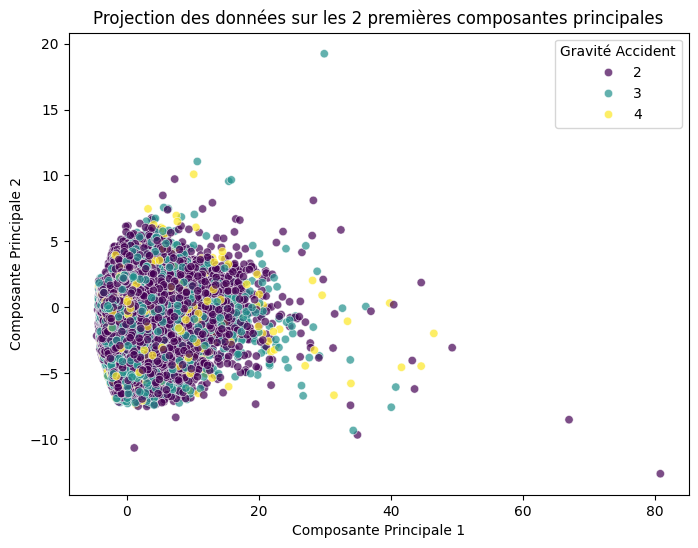

Nombre de composantes principales sélectionnées : 33


In [9]:
# Définition de la classe pour la transformation cyclique de l'heure
class CyclicalFeatures(BaseEstimator, TransformerMixin):
    """Transforme une colonne de type heure en variables cycliques sin et cos."""
    def __init__(self, period=24):
        self.period = period

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.astype(float)  # Assurer que les valeurs sont numériques
        X_sin = np.sin(2 * np.pi * X / self.period)
        X_cos = np.cos(2 * np.pi * X / self.period)
        return np.c_[X_sin, X_cos]  # Retourne un array 2D avec sin et cos

# Séparation des variables
X = df.drop(['lat', 'long', 'jour', 'mois', 'date', 'an', 'hrmn', 'dep', 'int', 'col', 'tué',
             'blessé_léger', 'indemne', 'blessé_hospitalisé', 'gravité_accident'], axis=1)
y = df['gravité_accident']

# Séparer en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Liste des variables catégorielles et cycliques
categorical_features = ['agg', 'atm']  # Encodage
cyclical_features = ['heure']  # Transformation cyclique
passthrough_features = ['nbv', 'vma', 'nationale_departementale_communale', 'autoroute', 'autre_route',
                        'sens_unique', 'bidirectionnel', 'route_seche', 'route_mouillee_enneigee',
                        'etat_route_autre', 'usager_count', 'total_sans_secu', 'total_ceinture',
                        'total_casque', 'total_secu_enfant', 'total_gilet', 'total_airbag', 'total_gants',
                        'total_gants_airbag', 'total_autre', 'place_conducteur', 'pax_AV', 'pax_AR',
                        'pax_Milieu', 'place_pieton', 'homme', 'femme', '0-17', '18-60', '61-95',
                        'obstacle_fixe', 'obstacle_mobile', 'aucun_choc', 'choc_AV', 'choc_AR',
                        'choc_cote', 'choc_tonneaux', 'VL_VU', '2roues_3roues_quad', 'PL', 'bus_car',
                        'velo_trott_edp', 'nbr_veh']

# Pipeline de preprocessing
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ('cyclical', CyclicalFeatures(), cyclical_features)
,( 'num', StandardScaler(), passthrough_features)])

# Pipeline de standardisation + ACP
pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('scaler', StandardScaler()),  # Normalisation avant l'ACP
    ('pca', PCA(n_components=0.95))  # Réduction pour conserver une variance expliquée de 95%
])

# Application du pipeline
X_pca = pipeline.fit_transform(X_train)

# Visualisation des résultats
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y_train, palette='viridis', alpha=0.7)
plt.xlabel("Composante Principale 1")
plt.ylabel("Composante Principale 2")
plt.title("Projection des données sur les 2 premières composantes principales")
plt.legend(title="Gravité Accident")
plt.show()

# Affichage de la variance expliquée
pca_model = pipeline.named_steps['pca']
explained_variance = pca_model.explained_variance_ratio_
print(f"Nombre de composantes principales sélectionnées : {pca_model.n_components_}")

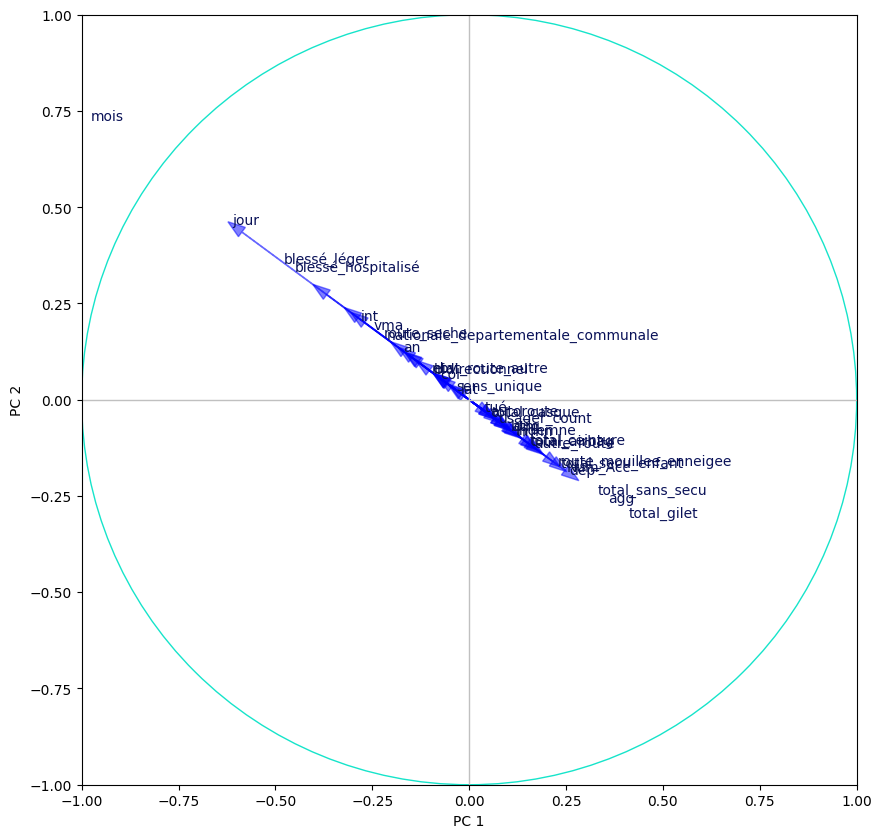

In [10]:
racine_valeurs_propres = np.sqrt(pca_model.explained_variance_)
corvar = np.zeros((33, 33))
for k in range(33):
    corvar[:, k] = pca_model.components_[:, k] * racine_valeurs_propres[k]

# Délimitation de la figure
fig, axes = plt.subplots(figsize=(10, 10))
axes.set_xlim(-1, 1)
axes.set_ylim(-1, 1)

# Affichage des variables
for j in range(33):
    plt.annotate(df.columns[j], (corvar[j, 0], corvar[j, 1]), color="#091158")
    plt.arrow(
        0,
        0,
        corvar[j, 0] * 0.6,
        corvar[j, 1] * 0.6,
        alpha=0.5,
        head_width=0.03,
        color="b",
    )

# Ajout des axes
plt.plot([-1, 1], [0, 0], color="silver", linestyle="-", linewidth=1)
plt.plot([0, 0], [-1, 1], color="silver", linestyle="-", linewidth=1)

# Cercle et légendes
cercle = plt.Circle((0, 0), 1, color="#16E4CA", fill=False)
axes.add_artist(cercle)
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.show()

